
# Planning a telescope observation

Let's build your first Markov Chain!

You are a real astronomer (not a theory guy like me) and are planning an expensive observational campaign. You want to know how likely it is that tomorrow night will be clear given the weather tonight (clear or cloudy). The key piece of information here is that the weather tomorrow depends on the weather today. From past history, you know that:

$$\text{p(clear tomorrow|cloudy today)}=0.5$$

which means that:

$$\text{p(cloudy tomorrow|cloudy today)}=0.5$$

We also have:

$$\text{p(cloudy tomorrow|clear today)}=0.1$$

Which means that:

$$\text{p(clear tomorrow|clear today)}=0.9.$$

- We can start with the sky conditions today and make predictions going forward more and more into the future.
- This will look like a big decision tree.
- After enough days, we'll reach equilibrium probabilities that have to do with the mean weather statistics (ignoring seasons) and we'll arrive at $$\text{p(clear)}=0.83,$$ and $$\text{p(cloudy)}=0.17.$$

You get the same answer for day $N$ as day $N+1$ and it doesn't matter whether it was clear or cloudy on the day that you started. The steps that we have taken in this process are, indeed, a MARKOV CHAIN.

## Tasks

- Start off on a cloudy day;
- Implement your weather forecast based on the above probabilities;
- Run your simulator for N days (with $N\gtrsim10^4$);
Prepare a plot with the number of days on the x axis and the cumulative fraction of, say, sunny days over the number of days so far on the y axis. This is called a trace-plot, showing how our estimate of $\text{p(clear)}$ evolves as the chain samples;
- Prepare a histogram of the above plot. This reveals the distribution of $\text{p(clear)}$;
- Use a summary statistics to determine the most likely value and an error on our estimate.

<strong>Important:</strong>

- In MCMC the process must be <strong>stationary</strong> which basically means that the chain statistics look the same no matter which chunk you look at, e.g. first half, second half, or every other point, etc.
- Obviously that isn't going to be the case in the early steps of the chain. In our example above, after some time the process was stationary, but not in the first few days.
So, there is a <strong>burn-in</strong> phase that needs to be discarded. How one determines the number of early steps to discard as burn-in is tricky, but <strong>you should always start with a traceplot of your samples!</strong>

## Tasks

- In the above example, experiment with chopping off different numbers of initial points as burn-in.

### More

- Redo the same for the Markovian process describing the stock market. If you've written your code well, this should require minor modifications.

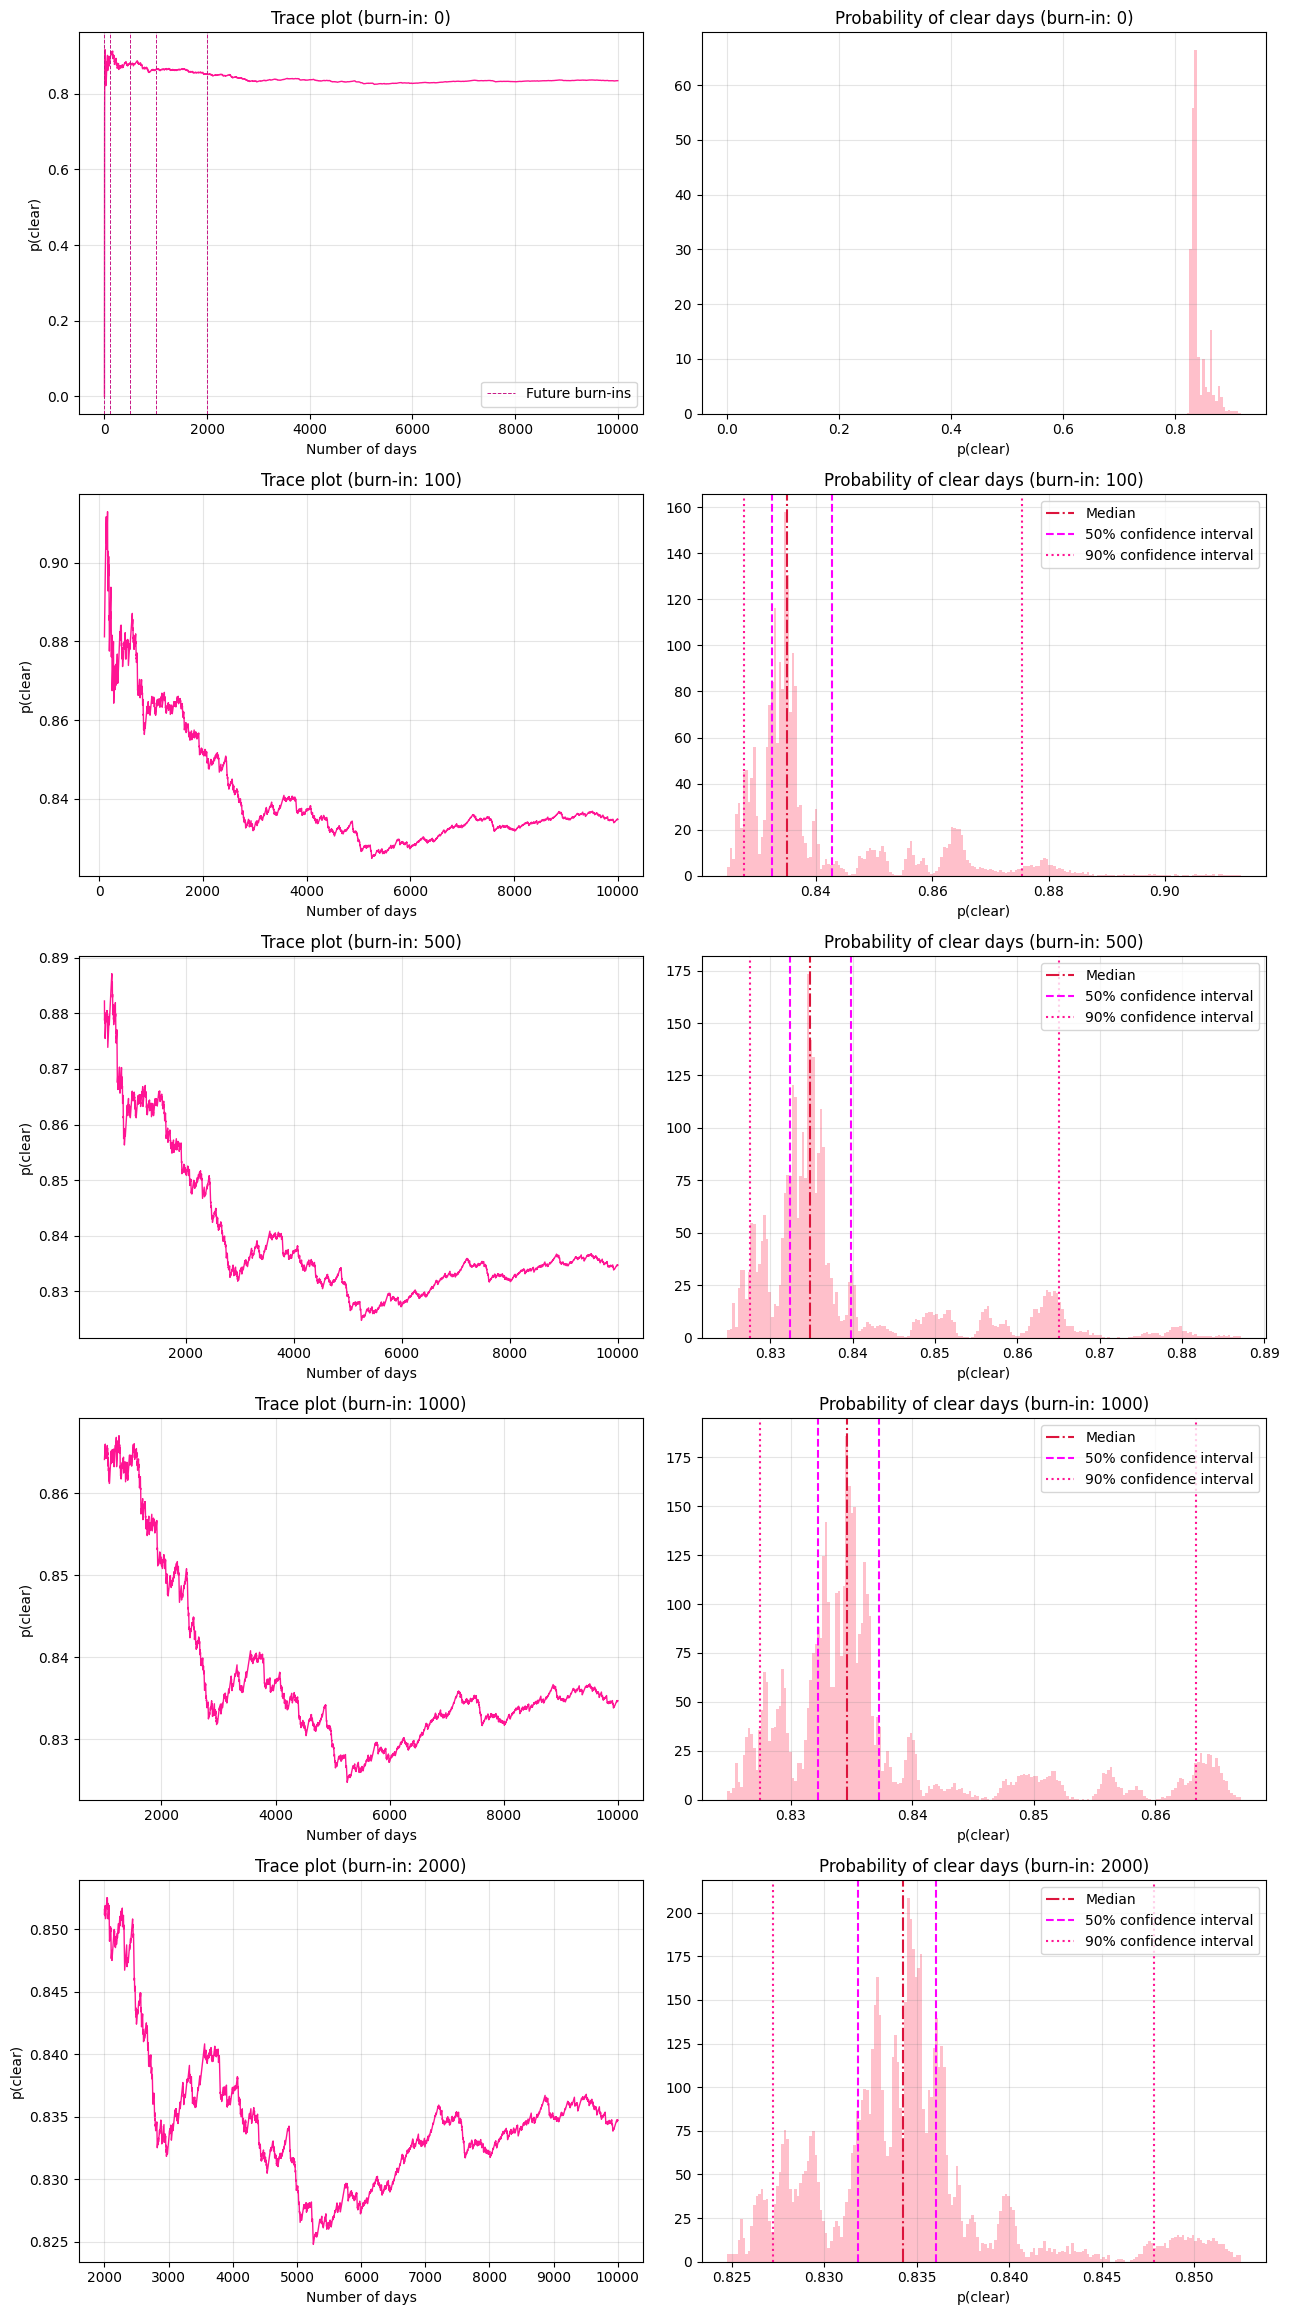

In [41]:
import numpy as np
import matplotlib.pyplot as plt

#---------------------------------------------------------------------------------
# Define the function that returns the weather tomorrow based on the weather today
def tomorrow(today):
    # Clear == 1, Cloudy == 0
    
    x = np.random.uniform(0, 1)
    
    if (today == 1):
        if (x < 0.9): return 1
        else: return 0
    if (today == 0):
        if (x < 0.5): return 1
        else: return 0

#---------------------------------------------------------------------------------

N = 10000
today = 0     # Start off with a cloudy day
weather = np.empty(N)

weather[0] = today

for i in range(N-1):
    weather[i+1] = tomorrow(weather[i])

p_clear =  np.cumsum(weather)/np.arange(1, N+1)

# Plotting the running average to find how p(clear) evolves, using different burn-ins

burn_in = [0, 100, 500, 1000, 2000] 

fig, ax = plt.subplots(len(burn_in), 2, figsize = (13, 5*len(burn_in)))

for i, b in enumerate(burn_in):

    ax[i, 0].plot(range(N)[b:], p_clear[b:], c = 'deeppink', lw = 1)
    ax[i, 0].set_xlabel('Number of days')
    ax[i, 0].set_ylabel('p(clear)')
    ax[i, 0].set_title('Trace plot (burn-in: %i)' % b)
    ax[i, 0].grid(c='grey', alpha = 0.2)

    # Marking in the first trace plot the burn-ins that are gonna be considered
    if (i == 0): ax[0, 0].axvline(b, ls = '--', lw = '0.7', c = 'mediumvioletred', label = 'Future burn-ins')
    else: ax[0, 0].axvline(b, ls = '--', lw = '0.7', c = 'mediumvioletred')
    ax[0, 0].legend(loc='lower right')
    
    ax[i, 1].hist(p_clear[b:], bins = 200, density = True, color = 'pink')
    ax[i, 1].set_xlabel('p(clear)')
    ax[i, 1].set_title('Probability of clear days (burn-in: %i)' % b)
    ax[i, 1].grid(c='grey', alpha = 0.2)

    # Computing the median and the 50% and 90% confidence intervals (using quantiles)
    # Not doing it for the first plot, without burn-in
    if (i != 0):
        ax[i, 1].axvline(np.median(p_clear[b:]), ls = '-.', lw = 1.5, c = 'crimson', label = 'Median')
        ax[i, 1].axvline(np.percentile(p_clear[b:], 25), ls = '--', lw = 1.5, c = 'fuchsia', label = '50% confidence interval')
        ax[i, 1].axvline(np.percentile(p_clear[b:], 75), ls = '--', lw = 1.5, c = 'fuchsia')
        ax[i, 1].axvline(np.percentile(p_clear[b:], 5), ls = ':', lw = 1.5, c = 'deeppink', label = '90% confidence interval')
        ax[i, 1].axvline(np.percentile(p_clear[b:], 95), ls = ':', lw = 1.5, c = 'deeppink')
        ax[i, 1].legend(loc='best')
    
plt.subplots_adjust(hspace=0.2)  
plt.tight_layout(rect=[0, 0.05, 1, 0.98], w_pad=1.5)
plt.show()

In [37]:
for b in burn_in:
    print(f"Discarding the first {b} points:\n\tmedian = {np.median(p_clear[b:]):.3f}\n" +
    f"\t50% confidence interval: {np.percentile(p_clear[b:], 25):.3f} - {np.percentile(p_clear[b:], 75):.3f}\n" +
    f"\t90% confidence interval: {np.percentile(p_clear[b:], 5):.3f} - {np.percentile(p_clear[b:], 95):.3f}\n")

Discarding the first 0 points:
	median = 0.840
	50% confidence interval: 0.837 - 0.844
	90% confidence interval: 0.832 - 0.847

Discarding the first 100 points:
	median = 0.840
	50% confidence interval: 0.837 - 0.844
	90% confidence interval: 0.833 - 0.847

Discarding the first 500 points:
	median = 0.841
	50% confidence interval: 0.837 - 0.844
	90% confidence interval: 0.834 - 0.847

Discarding the first 1000 points:
	median = 0.841
	50% confidence interval: 0.837 - 0.844
	90% confidence interval: 0.835 - 0.847

Discarding the first 2000 points:
	median = 0.842
	50% confidence interval: 0.837 - 0.844
	90% confidence interval: 0.835 - 0.848



We can now check how the results change by using different chunks of the Markov chain:

Using datapoints from 2000 to 5000:
	median = 0.836
	50% confidence interval: 0.834 - 0.840
	90% confidence interval: 0.831 - 0.850

Using datapoints from 3000 to 6000:
	median = 0.833
	50% confidence interval: 0.828 - 0.836
	90% confidence interval: 0.826 - 0.840

Using datapoints from 4000 to 7000:
	median = 0.830
	50% confidence interval: 0.828 - 0.833
	90% confidence interval: 0.826 - 0.835

Using datapoints from 5000 to 8000:
	median = 0.830
	50% confidence interval: 0.828 - 0.833
	90% confidence interval: 0.826 - 0.835

Using datapoints from 6000 to 9000:
	median = 0.833
	50% confidence interval: 0.832 - 0.835
	90% confidence interval: 0.829 - 0.836

Using datapoints from 7000 to 10000:
	median = 0.835
	50% confidence interval: 0.834 - 0.835
	90% confidence interval: 0.832 - 0.836



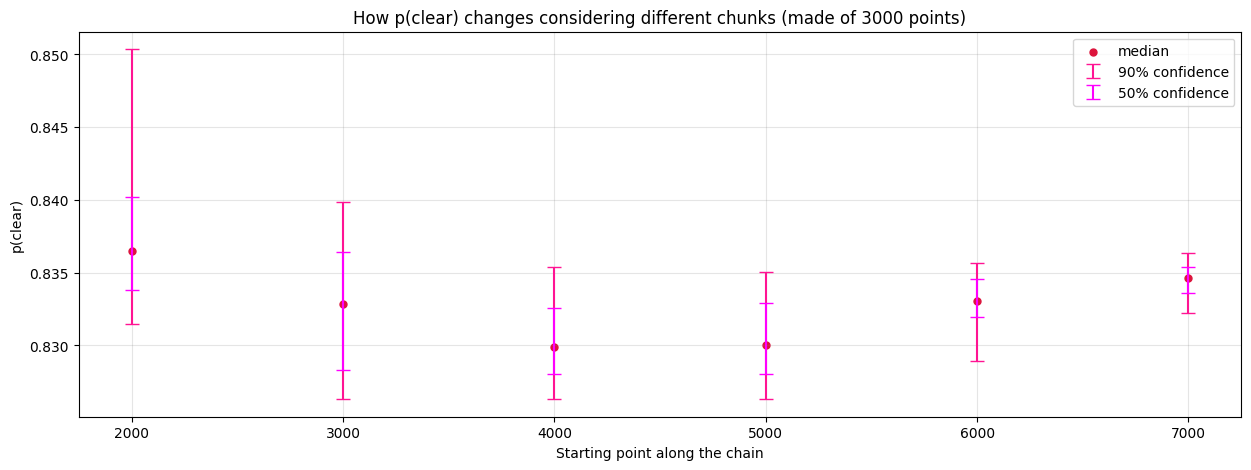

In [65]:
length = 3000     # How many datapoints to use
chunks = [2000, 3000, 4000, 5000, 6000, 7000]     # Starting points for each chunk. Still using a burn-in of 2000

plt.figure(figsize=(15, 5))

for c in chunks:
    median = np.median(p_clear[c:c+length])
    perc5 = np.percentile(p_clear[c:c+length], 5)
    perc25 = np.percentile(p_clear[c:c+length], 25)
    perc75 = np.percentile(p_clear[c:c+length], 75)
    perc95 = np.percentile(p_clear[c:c+length], 95)
    
    print(f"Using datapoints from {c} to {c+length}:\n\tmedian = {median:.3f}\n" +
    f"\t50% confidence interval: {perc25:.3f} - {perc75:.3f}\n" +
    f"\t90% confidence interval: {perc5:.3f} - {perc95:.3f}\n")
    if (c == min(chunks)):     # I want the labels only on the first iteration
        plt.errorbar(c, median, yerr=[[median-perc5], [perc95-median]], c = 'deeppink', ls = '', capsize = 5, label = '90% confidence')
        plt.errorbar(c, median, yerr=[[median-perc25], [perc75-median]], c = 'fuchsia', ls = '', fmt = '', capsize = 5, label = '50% confidence')
        plt.scatter(c, median, c = 'crimson', s = 25, label = 'median')
    
    else:
        plt.errorbar(c, median, yerr=[[median-perc5], [perc95-median]], c = 'deeppink', ls = '', capsize = 5)
        plt.errorbar(c, median, yerr=[[median-perc25], [perc75-median]], c = 'fuchsia', ls = '', capsize = 5)
        plt.scatter(c, median, c = 'crimson', s = 25)

plt.grid(c='grey', alpha = 0.2)
plt.xlabel('Starting point along the chain')
plt.ylabel('p(clear)')
plt.title('How p(clear) changes considering different chunks (made of %i points)' % length)
plt.legend()
plt.show()

## Applied at the stock market

Here's a scheme of the probabilities for the stock market, where the three scenarios are:
- Bull market = growing prices
- Stagnant market
- Bear market = decreasing prices


<center>
    <img src="https://github.com/Alice-Palladino/astrostatistics_bicocca_2024/blob/main/working/stock_market.png?raw=true" alt="Stock market probs" width="500">
</center>

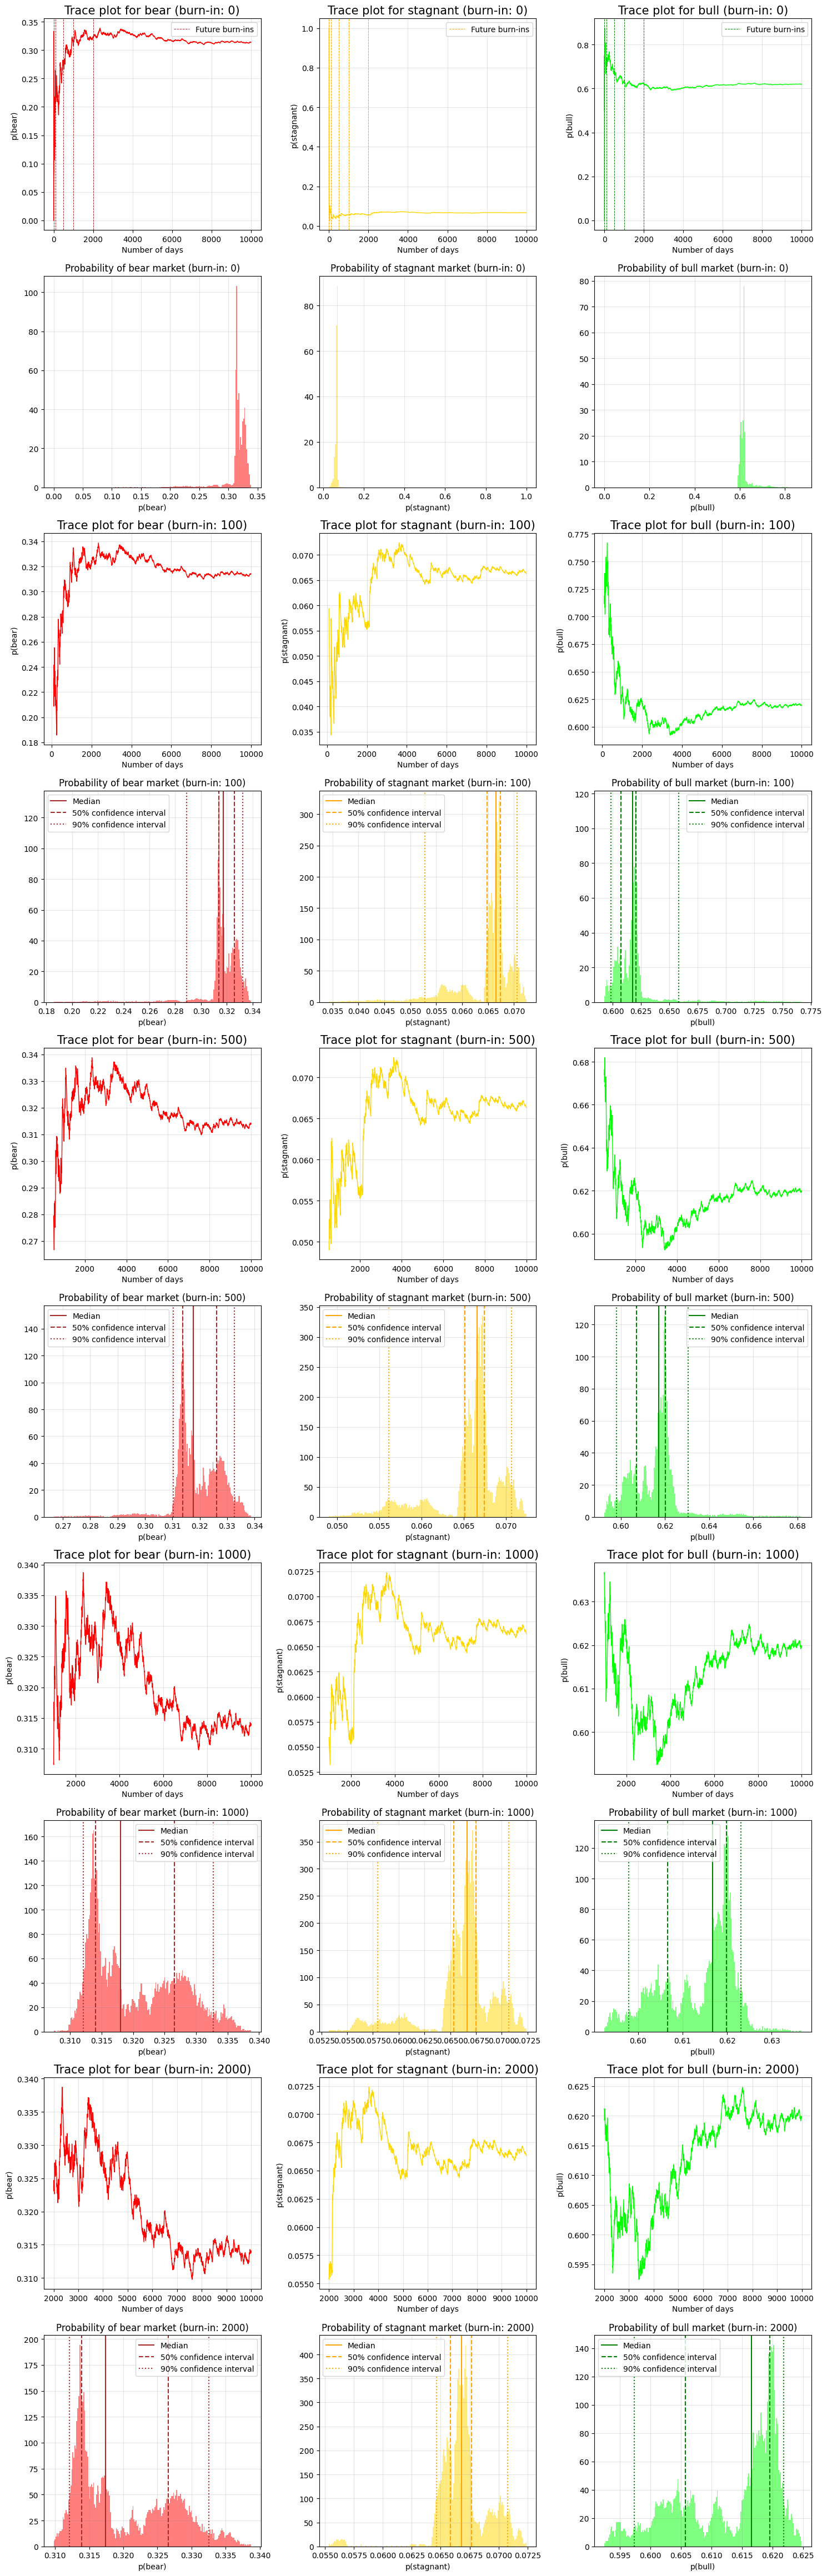

In [93]:
#---------------------------------------------------------------------------------
# Define the function that returns the market tomorrow based on the market today
def tomorrow(today):
    # Bear == 0, Stagnant == 1, Bull == 2
    
    x = np.random.uniform(0, 1)
    
    if (today == 0):
        if (x < 0.8): return 0
        elif (x >= 0.8 and x < 0.85): return 1
        else: return 2
            
    elif (today == 1):
        if (x < 0.25): return 0
        elif (x >= 0.25 and x < 0.75): return 1
        else: return 2
    
    elif (today == 2):
        if (x < 0.075): return 0
        elif (x >= 0.075 and x < 0.1): return 1
        else: return 2

#---------------------------------------------------------------------------------

N = 10000
today = 1     # Start off with a stagnant day
market = np.empty(N)

market[0] = today

# Since now I have three possible scenarios, I'm calculating p(stagnant), p(bear) and p(bull) as n_stagnant/n_tot etc
p_bear = np.empty(N)
p_stagnant = np.empty(N)
p_bull = np.empty(N)

if (today == 0): 
    p_bear[0] = 1
    p_stagnant[0] = 0
    p_bull[0] = 0
    n_bear = 1
    n_stagnant = 0
    n_bull = 0
    
elif (today == 1): 
    p_bear[0] = 0
    p_stagnant[0] = 1
    p_bull[0] = 0
    n_bear = 0
    n_stagnant = 1
    n_bull = 0
    
elif (today == 2): 
    p_bear[0] = 0
    p_stagnant[0] = 0
    p_bull[0] = 1
    n_bear = 0
    n_stagnant = 0
    n_bull = 1

for i in range(N-1):
    market[i+1] = tomorrow(market[i])

    if (market[i+1] == 0): n_bear += 1      
    elif (market[i+1] == 1): n_stagnant += 1
    elif (market[i+1] == 2): n_bull += 1

    p_bear[i+1] = n_bear/(i+2)     # For i = 0, I'm adding p_bear[1], the probability between 2 values
    p_stagnant[i+1] = n_stagnant/(i+2)
    p_bull[i+1] = n_bull/(i+2)


# Plotting how the probabilities evolve, using different burn-ins
burn_in = [0, 100, 500, 1000, 2000] 

fig, ax = plt.subplots(len(burn_in)*2, 3, figsize = (15, 10*len(burn_in)))

for i, b in enumerate(burn_in):

    # Add the trace plots
    ax[2*i, 0].plot(range(N)[b:], p_bear[b:], c = 'r', lw = 1)
    ax[2*i, 0].set_xlabel('Number of days')
    ax[2*i, 0].set_ylabel('p(bear)')
    ax[2*i, 0].set_title('Trace plot for bear (burn-in: %i)' % b, fontsize = 15)
    ax[2*i, 0].grid(c='grey', alpha = 0.2)

    ax[2*i, 1].plot(range(N)[b:], p_stagnant[b:], c = 'gold', lw = 1)
    ax[2*i, 1].set_xlabel('Number of days')
    ax[2*i, 1].set_ylabel('p(stagnant)')
    ax[2*i, 1].set_title('Trace plot for stagnant (burn-in: %i)' % b, fontsize = 15)
    ax[2*i, 1].grid(c='grey', alpha = 0.2)
    
    ax[2*i, 2].plot(range(N)[b:], p_bull[b:], c = 'lime', lw = 1)
    ax[2*i, 2].set_xlabel('Number of days')
    ax[2*i, 2].set_ylabel('p(bull)')
    ax[2*i, 2].set_title('Trace plot for bull (burn-in: %i)' % b, fontsize = 15)
    ax[2*i, 2].grid(c='grey', alpha = 0.2)

    # Marking in the first trace plot the burn-ins that are gonna be considered
    if (i == 0): 
        ax[0, 0].axvline(b, ls = '--', lw = '0.7', c = 'brown', label = 'Future burn-ins')
        ax[0, 1].axvline(b, ls = '--', lw = '0.7', c = 'orange', label = 'Future burn-ins')
        ax[0, 2].axvline(b, ls = '--', lw = '0.7', c = 'green', label = 'Future burn-ins')
    else: 
        ax[0, 0].axvline(b, ls = '--', lw = '0.7', c = 'brown')
        ax[0, 1].axvline(b, ls = '--', lw = '0.7', c = 'orange')
        ax[0, 2].axvline(b, ls = '--', lw = '0.7', c = 'green')
    ax[0, 0].legend(loc='best')
    ax[0, 1].legend(loc='best')
    ax[0, 2].legend(loc='best')

    # Add the histograms
    ax[2*i+1, 0].hist(p_bear[b:], bins = 200, density = True, color = 'r', alpha = 0.5)
    ax[2*i+1, 0].set_xlabel('p(bear)')
    ax[2*i+1, 0].set_title('Probability of bear market (burn-in: %i)' % b)
    ax[2*i+1, 0].grid(c='grey', alpha = 0.2)

    ax[2*i+1, 1].hist(p_stagnant[b:], bins = 200, density = True, color = 'gold', alpha = 0.5)
    ax[2*i+1, 1].set_xlabel('p(stagnant)')
    ax[2*i+1, 1].set_title('Probability of stagnant market (burn-in: %i)' % b)
    ax[2*i+1, 1].grid(c='grey', alpha = 0.2)

    ax[2*i+1, 2].hist(p_bull[b:], bins = 200, density = True, color = 'lime', alpha = 0.5)
    ax[2*i+1, 2].set_xlabel('p(bull)')
    ax[2*i+1, 2].set_title('Probability of bull market (burn-in: %i)' % b)
    ax[2*i+1, 2].grid(c='grey', alpha = 0.2)

    # Computing the median and the 50% and 90% confidence intervals (using quantiles)
    # Not doing it for the first plot, without burn-in
    if (i != 0):
        ax[2*i+1, 0].axvline(np.median(p_bear[b:]), ls = '-', lw = 1.5, c = 'brown', label = 'Median')
        ax[2*i+1, 0].axvline(np.percentile(p_bear[b:], 25), ls = '--', lw = 1.5, c = 'brown', label = '50% confidence interval')
        ax[2*i+1, 0].axvline(np.percentile(p_bear[b:], 75), ls = '--', lw = 1.5, c = 'brown')
        ax[2*i+1, 0].axvline(np.percentile(p_bear[b:], 5), ls = ':', lw = 1.5, c = 'brown', label = '90% confidence interval')
        ax[2*i+1, 0].axvline(np.percentile(p_bear[b:], 95), ls = ':', lw = 1.5, c = 'brown')
        ax[2*i+1, 0].legend(loc='best')

        ax[2*i+1, 1].axvline(np.median(p_stagnant[b:]), ls = '-', lw = 1.5, c = 'orange', label = 'Median')
        ax[2*i+1, 1].axvline(np.percentile(p_stagnant[b:], 25), ls = '--', lw = 1.5, c = 'orange', label = '50% confidence interval')
        ax[2*i+1, 1].axvline(np.percentile(p_stagnant[b:], 75), ls = '--', lw = 1.5, c = 'orange')
        ax[2*i+1, 1].axvline(np.percentile(p_stagnant[b:], 5), ls = ':', lw = 1.5, c = 'orange', label = '90% confidence interval')
        ax[2*i+1, 1].axvline(np.percentile(p_stagnant[b:], 95), ls = ':', lw = 1.5, c = 'orange')
        ax[2*i+1, 1].legend(loc='best')

        ax[2*i+1, 2].axvline(np.median(p_bull[b:]), ls = '-', lw = 1.5, c = 'green', label = 'Median')
        ax[2*i+1, 2].axvline(np.percentile(p_bull[b:], 25), ls = '--', lw = 1.5, c = 'green', label = '50% confidence interval')
        ax[2*i+1, 2].axvline(np.percentile(p_bull[b:], 75), ls = '--', lw = 1.5, c = 'green')
        ax[2*i+1, 2].axvline(np.percentile(p_bull[b:], 5), ls = ':', lw = 1.5, c = 'green', label = '90% confidence interval')
        ax[2*i+1, 2].axvline(np.percentile(p_bull[b:], 95), ls = ':', lw = 1.5, c = 'green')
        ax[2*i+1, 2].legend(loc='best')
 
plt.subplots_adjust(hspace=0.2)  
plt.tight_layout(rect=[0, 0.05, 1, 0.98], w_pad=1.5)
plt.show()


As a check, we can plot the traces together, to see that the probabilities add up to 1:

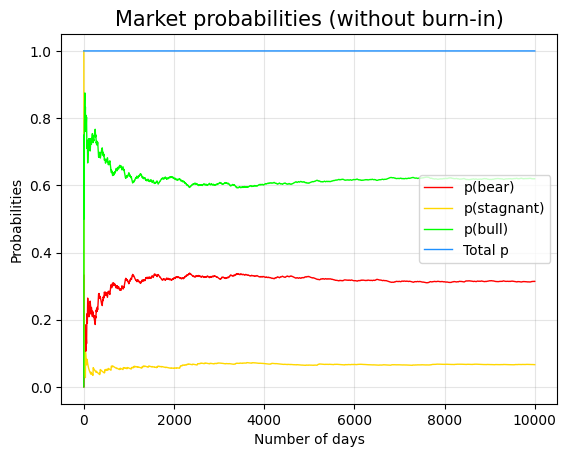

In [99]:
plt.plot(range(N), p_bear, c = 'r', lw = 1, label = 'p(bear)')
plt.plot(range(N), p_stagnant, c = 'gold', lw = 1, label = 'p(stagnant)')
plt.plot(range(N), p_bull, c = 'lime', lw = 1, label = 'p(bull)')
plt.plot(range(N), p_bear+p_stagnant+p_bull, c = 'dodgerblue', lw = 1, label = 'Total p')
plt.xlabel('Number of days')
plt.ylabel('Probabilities')
plt.title('Market probabilities (without burn-in)', fontsize = 15)
plt.grid(c='grey', alpha = 0.2)
plt.legend(loc='center right')
plt.show()